<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/Rented_Bikes_Prediction_(Adv_Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rented Bikes Prediction

The task of this homework is to train several advanced regression algorithms for the prediction of the number of rented bikes. It is also needed to tune the hyperparameters of all models and choose the best one.

In [ ]:
! pip install bds_courseware

In [ ]:
! pip install plotly

In [ ]:
! pip install pandas-profiling==3.2.0

In [ ]:
! pip install markupsafe==2.0.1

In [ ]:
!pip install catboost

In [ ]:
from bds_courseware import read_drive_dataset
from bds_courseware import print_dataset_description, print_module_datasets
from bds_courseware import HOMEWORK_DATASETS

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy
import random
import warnings
import math
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.multioutput import MultiOutputRegressor

from catboost import CatBoostRegressor

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

We use Bike Sharing Dataset that contains hourly statistics related to the years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA. The dataset is a part of the bds_courseware library.

In [ ]:
print("Dataset names: ", HOMEWORK_DATASETS.keys())
name = "bike_sharing_hour"
df = read_drive_dataset(*HOMEWORK_DATASETS[name])
print(df.head(2))
print(df.shape)

Dataset names:  dict_keys(['suicide_rates', 'car_perfs', 'brain', 'bank', 'air_quality', 'hypothyroid', 'movies', 'bike_sharing_day', 'bike_sharing_hour', 'quake'])
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
(17379, 17)



Dataset fields description:

	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit :
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [ ]:
df.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [ ]:
SEED = 844
TARGET = 'cnt'

In [ ]:
df['dteday'].value_counts()

2011-01-01    24
2012-04-03    24
2012-04-28    24
2012-04-29    24
2012-04-30    24
              ..
2011-01-26    16
2011-01-18    12
2012-10-30    11
2011-01-27     8
2012-10-29     1
Name: dteday, Length: 731, dtype: int64

I will drop the 'instant' column, as it doesn't bring any valuable information to our data and just duplicates the auto index column of the data frame. Also, I will convert 'dteday' into datetime format for consistency reasons. But I feel that this column is redundant as we have separate columns for year, month, and weekday, so I will probably get rid of it before model fitting.  

In [ ]:
df = df.drop('instant', axis=1)

In [ ]:
df['dteday'] = pd.to_datetime(df['dteday'], format='%Y-%m-%d')

In [ ]:
df.describe()

season            yr          mnth            hr       holiday  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       2.501640      0.502561      6.537775     11.546752      0.028770   
std        1.106918      0.500008      3.438776      6.914405      0.167165   
min        1.000000      0.000000      1.000000      0.000000      0.000000   
25%        2.000000      0.000000      4.000000      6.000000      0.000000   
50%        3.000000      1.000000      7.000000     12.000000      0.000000   
75%        3.000000      1.000000     10.000000     18.000000      0.000000   
max        4.000000      1.000000     12.000000     23.000000      1.000000   

            weekday    workingday    weathersit          temp         atemp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       3.003683      0.682721      1.425283      0.496987      0.475775   
std        2.005771      0.465431      0.639357      0.192556      0.171850   
min        0.000000      0.000000      1.000000      0.020000      0.000000   
25%        1.000000      0.000000      1.000000      0.340000      0.333300   
50%        3.000000      1.000000      1.000000      0.500000      0.484800   
75%        5.000000      1.000000      2.000000      0.660000      0.621200   
max        6.000000      1.000000      4.000000      1.000000      1.000000   

                hum     windspeed           cnt  
count  17379.000000  17379.000000  17379.000000  
mean       0.627229      0.190098    189.463088  
std        0.192930      0.122340    181.387599  
min        0.000000      0.000000      1.000000  
25%        0.480000      0.104500     40.000000  
50%        0.630000      0.194000    142.000000  
75%        0.780000      0.253700    281.000000  
max        1.000000      0.850700    977.000000

Quick checking of distributions of variables that we have:

In [ ]:
df.drop(['cnt', 'casual', 'registered'],axis=1).boxplot(rot = 45);

In [ ]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Profiling Report shows a few things about the data:

*   Dataset contains 5 categorical, 9 numerical, and 1 DateTime features.  
*   The most variables have low to medium correlation with the target.
*   We have a few variables highly correlated between with each others. This might be the reason of multicolleniarity so we probably need to get rid of some of them.
*   Distributions of numeric variables are close to normal.
*   We have no missing data in our dataset.
*   We have no duplicates in our dataset.


In [ ]:
df['weathersit'].value_counts()

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

We have only three observations in weather class 4 ('Heavy rain'). This is not enough for model training to determine this class. So I decided to merge it with the previous class 3 ('Light rain').

In [ ]:
df['weathersit'].replace(to_replace=4, value=3, inplace=True)

In [ ]:
df['weathersit'].value_counts()

1    11413
2     4544
3     1422
Name: weathersit, dtype: int64

Let's see on the targer variable distribution:

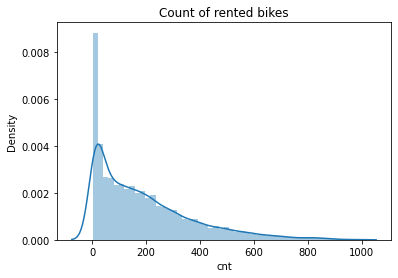

In [ ]:
ax = sns.distplot(df[TARGET], norm_hist=True)
ax.set_title('Count of rented bikes');

We have two temperature variables in our dataset - 'temp' which indicates the actual temperature value recorded on this day, and 'atemp' which indicates subjective "feeling temperature". Let's plot their distributions using scatterplot:

In [ ]:
y_mean = df.groupby(['temp'])['cnt'].mean()
x_tmp = np.sort(df['temp'].unique())
title = 'Rented bikes vs Temperature'
fig= px.scatter(df, x='temp', y='cnt',
            color='season', template='none', opacity=0.8,  title=title)
fig.add_traces(go.Scatter(x=x_tmp, y=y_mean, name='Count mean'))
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.9
))
fig.show()

In [ ]:
y_mean = df.groupby(['atemp'])['cnt'].mean()
x_tmp = np.sort(df['atemp'].unique())
title = 'Rented bikes vs Feeling Temperature'
fig= px.scatter(df, x='atemp', y='cnt',
            color='season', template='none', opacity=0.8,  title=title)
fig.add_traces(go.Scatter(x=x_tmp, y=y_mean, name='Count mean'))
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.9
))
fig.show()

As we can see on these two plots in general for both measures we have similar trends - if the temperature is low we see a little usage of rental bikes, while temperatures go up the number of bikes rented also goes up until some point after which the average of rented bikes starts to decline. This is intuitively understandable as after some temperature level fewer people feel comfortable commuting by bike and also fewer use bikes for recreation.
As these two variables are highly correlated I need to decide which one to keep and which one to drop. Therefore I need to estimate which of the two is more important to predict the number of bikes rented. My intuition is that feeling temperature is more important because usually people rely not on the actual temperature but on their feeling when deciding to take a bike or not. This is indirectly confirmed by the behavior of graphs at extreme edges: while at the minimum and maximum feeling temperatures, we see low numbers of rentals, on the actual temperatures this tendency isn't so clear - for maximum actual temperatures we see a much higher number of rentals. That means that there are deviations out of common tendency possible if we use actual temperature which could affect the predictions of some models.  

In [ ]:
y_mean = df.groupby(['hum'])['cnt'].mean()
y_casual = df.groupby(['hum'])['casual'].mean()
y_registered = df.groupby(['hum'])['registered'].mean()
x_tmp = np.sort(df['hum'].unique())
title = 'Rented bikes vs Humidity'
fig= px.scatter(df, x='hum', y='cnt',
            color='season', template='none', opacity=0.8,  title=title)
fig.add_traces(go.Scatter(x=x_tmp, y=y_mean, name='Total count mean'))
fig.add_traces(go.Scatter(x=x_tmp, y=y_casual, name='Casual count mean'))
fig.add_traces(go.Scatter(x=x_tmp, y=y_registered, name='Registered count mean'))
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.85
))
fig.show()

On the humidity plot, we also see "uncomfortable" zones where few people choose to take a bike instead of other transport or probably even stay at home - these are extreme edges of near zero and near 100% humidity.
For the rest of the range, we can observe the peak of the number of rented bikes between 20 and 30% humidity and a smooth decline in the number while humidity is raised toward 100%.
I also plotted mean trends for 'casual' and 'registered' separately and here is also some pattern observed - casual rentals decline to almost zero in uncomfortable zones while the 'registered' is still relatively high. This is explained by the fact that 'casual' rentals are mostly for recreational use while 'registered' is probably used for commute and that's why their number is less dependent on the weather conditions.

In order to observe and investigate the cyclical pattern of the count of bike rentals let's plot the dependency of the mean number of rents by days of the week and hours:

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday", "hr"])["cnt"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",)


As we can see there is a pattern - we have two distinct peaks in each working day - this are rush hours when people commute to their jobs and back home, areas of minimum usage during nights, and average level recreative usage of bikes during weekends.

### Feature engineering and processing

In order to reflect the cyclical nature of time related variables (month, hour, weekday) I will use trigonometric (sin, cos) transformation of these features. Here are the auxiliary functions used for these transformations:

In [ ]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
df['mnth_sin'] = sin_transformer(12).fit_transform(df['mnth'])
df['mnth_cos'] = cos_transformer(12).fit_transform(df['mnth'])
df['weekday_sin'] = sin_transformer(7).fit_transform(df['weekday'])
df['weekday_cos'] = cos_transformer(7).fit_transform(df['weekday'])
df['hr_sin'] = sin_transformer(24).fit_transform(df['hr'])
df['hr_cos'] = cos_transformer(24).fit_transform(df['hr'])

Now we have two new features fo each ordinal time feature that together encode equivalent information in a non-monotonic way, and without any jump between the first and the last value of the periodic range.

Defining auxiliary arrays with the names of different kinds of features for further processing:

In [ ]:
cat_cols = ['yr','season', 'holiday', 'workingday', 'weathersit']
time_cols = ['mnth', 'weekday', 'hr']
time_modified_cols = ['mnth_sin', 'mnth_cos',  'weekday_sin', 'weekday_cos', 'hr_sin', 'hr_cos']
multi_target = ['casual', 'registered']

In [ ]:
cat_encoded_cols = []
for col in cat_cols:
  val_qty = len(df[col].unique())
  for i in range(1, val_qty):
     col_name = col + '_' + str(i)
     cat_encoded_cols.append(col_name)
len(cat_encoded_cols)

8

Encoding categorical features with OneHotEncoding:

In [ ]:
cat_encoder = OneHotEncoder(drop='first', sparse=False)
cat_encoded = cat_encoder.fit_transform(df[cat_cols])
df_cat_encoded = pd.DataFrame(cat_encoded, columns=cat_encoded_cols, dtype='int32')

In [ ]:
df_cat_encoded.head()

yr_1  season_1  season_2  season_3  holiday_1  workingday_1  weathersit_1  \
0     0         0         0         0          0             0             0   
1     0         0         0         0          0             0             0   
2     0         0         0         0          0             0             0   
3     0         0         0         0          0             0             0   
4     0         0         0         0          0             0             0   

   weathersit_2  
0             0  
1             0  
2             0  
3             0  
4             0

In [ ]:
df_cat_encoded['holiday_1'].value_counts()

0    16879
1      500
Name: holiday_1, dtype: int64

Defining dataframe with time-related features:

In [ ]:
df_time = df[time_modified_cols]

In [ ]:
df_time

mnth_sin  mnth_cos  weekday_sin  weekday_cos    hr_sin    hr_cos
0      5.000000e-01  0.866025    -0.781831      0.62349  0.000000  1.000000
1      5.000000e-01  0.866025    -0.781831      0.62349  0.258819  0.965926
2      5.000000e-01  0.866025    -0.781831      0.62349  0.500000  0.866025
3      5.000000e-01  0.866025    -0.781831      0.62349  0.707107  0.707107
4      5.000000e-01  0.866025    -0.781831      0.62349  0.866025  0.500000
...             ...       ...          ...          ...       ...       ...
17374 -2.449294e-16  1.000000     0.781831      0.62349 -0.965926  0.258819
17375 -2.449294e-16  1.000000     0.781831      0.62349 -0.866025  0.500000
17376 -2.449294e-16  1.000000     0.781831      0.62349 -0.707107  0.707107
17377 -2.449294e-16  1.000000     0.781831      0.62349 -0.500000  0.866025
17378 -2.449294e-16  1.000000     0.781831      0.62349 -0.258819  0.965926

[17379 rows x 6 columns]

Defining the numerical features data frame:

In [ ]:
df_num = df.drop([TARGET,'dteday', *cat_cols, *time_cols, *time_modified_cols, *multi_target], axis=1)

In [ ]:
df_num

temp   atemp   hum  windspeed
0      0.24  0.2879  0.81     0.0000
1      0.22  0.2727  0.80     0.0000
2      0.22  0.2727  0.80     0.0000
3      0.24  0.2879  0.75     0.0000
4      0.24  0.2879  0.75     0.0000
...     ...     ...   ...        ...
17374  0.26  0.2576  0.60     0.1642
17375  0.26  0.2576  0.60     0.1642
17376  0.26  0.2576  0.60     0.1642
17377  0.26  0.2727  0.56     0.1343
17378  0.26  0.2727  0.65     0.1343

[17379 rows x 4 columns]

Dropping 'temp' as I have decided previously:

In [ ]:
df_num = df_num.drop('temp', axis=1)

Defining X as a concatenation of categorical, time, and numerical sub-dataframes, and y:

In [ ]:
X = pd.concat([df_time, df_cat_encoded, df_num], axis = 1)
y = df[TARGET]

In [ ]:
X.columns

Index(['mnth_sin', 'mnth_cos', 'weekday_sin', 'weekday_cos', 'hr_sin',
       'hr_cos', 'yr_1', 'season_1', 'season_2', 'season_3', 'holiday_1',
       'workingday_1', 'weathersit_1', 'weathersit_2', 'atemp', 'hum',
       'windspeed'],
      dtype='object')

Randomly splitting for train and test datasets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, shuffle=True, test_size=0.1)

In [ ]:
def evaluate_model(train, test, tr_y, test_y, est):
    # Fit the model with given train_X/train_y and calculate metrics (RMSE, R2-score, MAE)
    est.fit(train.values, tr_y)
    pred_val = est.predict(test.values)
    pred_train = est.predict(train.values)

    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))],
        'test_RMSE': [np.sqrt(mean_squared_error(test_y, pred_val))],
        'train_R2': [r2_score(tr_y, pred_train)],
        'test_R2': [r2_score(test_y, pred_val)],
        'train_MAE': [mean_absolute_error(tr_y, pred_train)],
        'test_MAE': [mean_absolute_error(test_y, pred_val)]
    }), train.columns

We are now ready to train some models and explore the results:

### KNN Regressor

In [ ]:
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)
y_pred = knr.predict(X_test)
scores, colnames = evaluate_model(X_train, X_test, y_train, y_test, knr)
scores

train_RMSE  test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0   54.363703  73.294732  0.909754  0.843103  33.532549  45.035443

I am going to use hyperopt library to evaluate hypers for KNN:

In [ ]:
def hyperopt_train_test(params):
    knn_reg = KNeighborsRegressor(**params)
    return cross_val_score(knn_reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=5).mean()
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,10)),
    'weights': hp.choice('weights', ['distance', 'uniform']),
    #'p': hp.choice('p', range(1,4)),
}
def f(params):
    mae = hyperopt_train_test(params)
    return {'loss': -mae, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=50, trials=trials)
print(f'best: {best}')

100%|██████████| 50/50 [01:03<00:00,  1.27s/it, best loss: 41.66299011033376]
best: {'n_neighbors': 2, 'weights': 0}


We can see loss function values depending on the 'n_neighbor' hyperparameter values on the plot below. Data was extracted from Trials object of hyperopt library:

Text(0, 0.5, 'cross validation MAE')

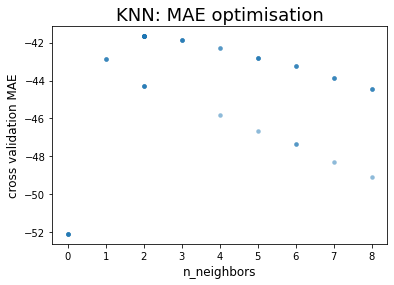

In [ ]:
f, ax = plt.subplots(1)#, figsize=(10,10))
xs = [t['misc']['vals']['n_neighbors'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('KNN: MAE optimisation', fontsize=18)
ax.set_xlabel('n_neighbors', fontsize=12)
ax.set_ylabel('cross validation MAE', fontsize=12)

So let's train KNN with the optimal parameters and explore if the results will better.

In [ ]:
knr = KNeighborsRegressor(n_neighbors=2, weights='distance')
scores, colnames = evaluate_model(X_train, X_test, y_train, y_test, knr)
scores

train_RMSE  test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0    0.492868  68.260465  0.999993  0.863915   0.010551  40.940628

They have slightly improved. So I am taking this as the final score for KNN.  **R2=0.86, MAE=40.94**

### Decision Tree Regressor

In [ ]:
dtr = DecisionTreeRegressor(criterion ='absolute_error')

scores, colnames = evaluate_model(X_train, X_test, y_train, y_test, dtr)
scores

train_RMSE  test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0    0.492868   64.65427  0.999993  0.877914   0.010549  36.168585

Decision Tree with default settings gives a score better than KNN. Let's try to improve it by hyperparameters tuning:

This time I will use RandomizedSearchCV for hypers evaluation:

In [ ]:
parameters = {'min_samples_leaf'    : sp_randInt(1, 100),
              'min_samples_split' : sp_randInt(1, 100),
              'max_depth'    : sp_randInt(4, 100)
             }

randm_src = RandomizedSearchCV(estimator=dtr, param_distributions = parameters,
                               cv = 2, n_iter = 100, n_jobs=-1)
randm_src.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=DecisionTreeRegressor(criterion='absolute_error'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f84d24aafa0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f84d24aac10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f84d24aae80>})

In [ ]:
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 DecisionTreeRegressor(criterion='absolute_error', max_depth=79,
                      min_samples_leaf=7, min_samples_split=7)

 The best score across ALL searched params:
 0.8914809580005232

 The best parameters across ALL searched params:
 {'max_depth': 79, 'min_samples_leaf': 7, 'min_samples_split': 7}


Training the model with hyper's values obtained by RandomizedSearch:

In [ ]:
dtr = DecisionTreeRegressor(criterion ='absolute_error', max_depth=79, max_features = 'auto',
                            min_samples_leaf = 7, min_samples_split = 7, random_state = SEED)

scores, colnames = evaluate_model(X_train, X_test, y_train, y_test, dtr)
scores

train_RMSE  test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0   42.598214  58.481867  0.944589  0.900112  21.970334  33.032509

Scores have improved. Final score for Decision Tree: **R2=0.90, MAE=33.03**

### Random Forest Regressor

In [ ]:
rfr = RandomForestRegressor(criterion="absolute_error", n_estimators=100)

scores, colnames = evaluate_model(X_train, X_test, y_train, y_test, rfr)
scores

train_RMSE  test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0   16.230749  46.934258  0.991956  0.935665   9.767128  26.705981

Random Forest gave its best result with default settings. Further evaluating with hyperopt and RandomizedSearch didn't give a combination that would improve the score. Probably I did something wrong. Need to get back to this later to clarify.

In [ ]:
def hyperopt_train_test(params):
    rf_reg = RandomForestRegressor(
        criterion ='absolute_error',
        random_state = SEED,
        **params
    )
    return cross_val_score(rf_reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=5).mean()

space = {
    'n_estimators': hp.choice('n_estimators', [10,25,50,65]),
    'max_depth': hp.choice('max_depth', [None, 3, 5, 10, 50]),
    'min_samples_split': hp.choice('min_samples_split', [15,30,50,100]),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', [25,50,75,100]),
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2'])
    }

def f(params):
    mae = hyperopt_train_test(params)
    return {'loss': -mae, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=50, trials=trials)
print(f'best: {best}')

100%|██████████| 50/50 [4:37:48<00:00, 333.37s/it, best loss: 36.31731083210146]
best: {'max_depth': 4, 'max_features': 0, 'max_leaf_nodes': 3, 'min_samples_split': 1, 'n_estimators': 3}


In [ ]:
rfr_rs = RandomForestRegressor(criterion="absolute_error", n_estimators=100)
parameters = {'n_estimators'  :     sp_randInt(10, 100),
              'max_leaf_nodes'    : sp_randInt(1, 100),
              'min_samples_split' : sp_randInt(10, 100),
              'max_depth'    :      sp_randInt(2, 100),
               }

randm_src = RandomizedSearchCV(estimator=rfr_rs, param_distributions = parameters,
                               cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=RandomForestRegressor(criterion='absolute_error'),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3bb5e66910>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3bb5e77fa0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3bb6a01580>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3bb5e77c10>})

In [ ]:
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(criterion='absolute_error', max_depth=82,
                      max_leaf_nodes=86, min_samples_split=56, n_estimators=86)

 The best score across ALL searched params:
 0.883378424165204

 The best parameters across ALL searched params:
 {'max_depth': 82, 'max_leaf_nodes': 86, 'min_samples_split': 56, 'n_estimators': 86}


In [ ]:
rfr = RandomForestRegressor(criterion='absolute_error', max_depth=82,
                      max_leaf_nodes=86, min_samples_split=56, n_estimators=100)

scores, colnames = evaluate_model(X_train, X_test, y_train, y_test, rfr)
scores

train_RMSE  test_RMSE  train_R2  test_R2  train_MAE  test_MAE
0   59.914635  65.111783  0.890383  0.87618  38.705643  40.13882

As I failed to improve the score by the tuning of hyperparameters I keep the initial results given by Random Forest as the final ones: **R2=0.94, MAE=26.71**

### CatBoost Regressor

In [ ]:
cb_reg = CatBoostRegressor()
scores, colnames = evaluate_model(X_train, X_test, y_train, y_test, cb_reg)
scores

Learning rate set to 0.063223
0:	learn: 172.6978118	total: 63.7ms	remaining: 1m 3s
1:	learn: 165.9205226	total: 69.2ms	remaining: 34.5s
2:	learn: 159.9765882	total: 77.4ms	remaining: 25.7s
3:	learn: 153.1044986	total: 89.9ms	remaining: 22.4s
4:	learn: 147.2336843	total: 96.4ms	remaining: 19.2s
5:	learn: 141.6584659	total: 105ms	remaining: 17.4s
6:	learn: 136.9299333	total: 109ms	remaining: 15.5s
7:	learn: 132.6830385	total: 114ms	remaining: 14.1s
8:	learn: 128.9376362	total: 119ms	remaining: 13.1s
9:	learn: 125.0104573	total: 131ms	remaining: 13s
10:	learn: 120.9864035	total: 136ms	remaining: 12.2s
11:	learn: 116.8613004	total: 140ms	remaining: 11.5s
12:	learn: 113.0372726	total: 143ms	remaining: 10.9s
13:	learn: 109.8468188	total: 146ms	remaining: 10.3s
14:	learn: 107.1482841	total: 150ms	remaining: 9.86s
15:	learn: 104.3684389	total: 155ms	remaining: 9.52s
16:	learn: 102.0068283	total: 162ms	remaining: 9.39s
17:	learn: 99.1981011	total: 171ms	remaining: 9.32s
18:	learn: 97.1648265	to

train_RMSE  test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0   30.282089  41.053713  0.971998  0.950776  19.784464  24.569913

In [ ]:
scores

train_RMSE  test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0   30.282089  41.053713  0.971998  0.950776  19.784464  24.569913

The initial score of the CatBoost model looks quite good. MAE is the least of all the previously trained models. Let's try to improve it:

In [ ]:
rs_cb = CatBoostRegressor(loss_function='MAE')


grid = {'learning_rate': sp_randFloat(0.05, 0.2),
        'depth': sp_randInt(2, 15),
        'l2_leaf_reg': sp_randInt(2, 15),
        'iterations': sp_randInt(1000, 3000),}

randm_src = RandomizedSearchCV(estimator=rs_cb, param_distributions = grid,
                               cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train, y_train)

0:	learn: 128.5301383	total: 56.6ms	remaining: 56.7s
1:	learn: 121.7326947	total: 134ms	remaining: 1m 7s
2:	learn: 114.2934956	total: 193ms	remaining: 1m 4s
3:	learn: 107.4619149	total: 246ms	remaining: 1m 1s
4:	learn: 101.7435860	total: 303ms	remaining: 1m
5:	learn: 96.1632205	total: 352ms	remaining: 58.6s
6:	learn: 91.2287080	total: 380ms	remaining: 54.1s
7:	learn: 86.5728115	total: 406ms	remaining: 50.5s
8:	learn: 81.9383738	total: 432ms	remaining: 47.8s
9:	learn: 78.0486985	total: 458ms	remaining: 45.5s
10:	learn: 74.1219464	total: 484ms	remaining: 43.7s
11:	learn: 70.3168085	total: 512ms	remaining: 42.3s
12:	learn: 67.5502489	total: 539ms	remaining: 41.1s
13:	learn: 64.8729607	total: 572ms	remaining: 40.4s
14:	learn: 62.3396923	total: 599ms	remaining: 39.5s
15:	learn: 59.7572514	total: 625ms	remaining: 38.6s
16:	learn: 57.0614641	total: 651ms	remaining: 37.8s
17:	learn: 54.6217364	total: 677ms	remaining: 37.1s
18:	learn: 52.7384834	total: 705ms	remaining: 36.5s
19:	learn: 50.69418

RandomizedSearchCV(cv=2,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f3bac3cae80>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3bac3ca700>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3bb69c25e0>,
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3bb69c23a0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3bac3caf70>})

In [ ]:
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.9522142945086796

 The best parameters across ALL searched params:
 {'depth': 11, 'iterations': 1004, 'l2_leaf_reg': 8, 'learning_rate': 0.0696817867899811}


In [ ]:
cb_reg = CatBoostRegressor(loss_function='MAE', learning_rate=0.06968, l2_leaf_reg=8, depth=11, iterations=1004 )
scores, colnames = evaluate_model(X_train, X_test, y_train, y_test, cb_reg)
scores

0:	learn: 129.8341410	total: 28.9ms	remaining: 29s
1:	learn: 122.2634463	total: 65.3ms	remaining: 32.7s
2:	learn: 115.0621947	total: 111ms	remaining: 36.9s
3:	learn: 108.2907014	total: 157ms	remaining: 39.2s
4:	learn: 102.0972422	total: 205ms	remaining: 40.9s
5:	learn: 96.2077627	total: 236ms	remaining: 39.3s
6:	learn: 90.8800615	total: 258ms	remaining: 36.7s
7:	learn: 86.0049277	total: 279ms	remaining: 34.7s
8:	learn: 81.7578569	total: 299ms	remaining: 33s
9:	learn: 77.5094587	total: 319ms	remaining: 31.7s
10:	learn: 73.5897734	total: 344ms	remaining: 31s
11:	learn: 69.8612386	total: 364ms	remaining: 30.1s
12:	learn: 66.6753934	total: 384ms	remaining: 29.3s
13:	learn: 64.0974287	total: 404ms	remaining: 28.6s
14:	learn: 61.6332791	total: 424ms	remaining: 28s
15:	learn: 59.0929397	total: 446ms	remaining: 27.6s
16:	learn: 56.9089835	total: 467ms	remaining: 27.1s
17:	learn: 54.4493466	total: 488ms	remaining: 26.7s
18:	learn: 52.5413935	total: 511ms	remaining: 26.5s
19:	learn: 50.5025343	t

train_RMSE  test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0   15.675852  39.915601  0.992496  0.953468   6.675339  22.819069

In [ ]:
scores

train_RMSE  test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0   15.675852  39.915601  0.992496  0.953468   6.675339  22.819069

Looks very good. I keep this score as the final one: **R2=0.95, MAE=22.82**

### Feature Importance

One of the tasks I have is to determine which features have a greater influence on the target than others. I decided to use the embedded CatBoost function which gives the importance score for all the features:

In [ ]:
feature_importance = cb_reg.get_feature_importance(prettified=True)
print('feature_importance', feature_importance)

feature_importance    Feature Id  Importances
0           5    32.916128
1           4    16.263706
2          11    11.185709
3           6     9.912208
4          15     9.373736
5          16     3.566973
6           2     2.810380
7           0     2.635013
8           3     2.508190
9           1     2.304478
10         13     2.024436
11          9     1.695677
12         17     1.415534
13         12     0.610683
14          7     0.507731
15          8     0.153002
16         10     0.116240
17         14     0.000177


In [ ]:
top_features = feature_importance.iloc[0:10]
feature_num = top_features['Feature Id']
cols = pd.DataFrame(X.columns, columns=['Feature'])
cols.iloc[feature_num]

Feature
5         hr_cos
4         hr_sin
11  workingday_1
6           yr_1
15         atemp
16           hum
2    weekday_sin
0       mnth_sin
3    weekday_cos
1       mnth_cos

As we can see top-6 features that responsible for over 80% of model's predictive performance are:
1.   Hour (cos transformed)
2.   Hour (sin transformed)
3.   Workingday
4.   Year
5.   Feeling temperature
6.   Humidity

So answering one of the questions in the task - the current hour is much more important than the current season because daily fluctuations in the number of rented bikes are much more distinctive than seasonal fluctuations. And feeling temperature is more important than actual temperature (I've speculated about this earlier).

### SVR

I have one more regression model to explore - SVR. Let's try it out:

In [ ]:
svr = SVR()
scores, colnames = evaluate_model(X_train, X_test, y_train, y_test, svr)
scores

train_RMSE   test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0  126.563296  129.398816  0.510868  0.510975  74.669249  76.791638

In [ ]:
grid = {'kernel': ['poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'],
        'C': sp_randInt(2, 1000),
        }

randm_src = RandomizedSearchCV(estimator=svr, param_distributions = grid, scoring='neg_mean_squared_error',
                               cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train, y_train)

RandomizedSearchCV(cv=2, estimator=SVR(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3ba71c1f70>,
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['poly', 'rbf', 'sigmoid']},
                   scoring='neg_mean_squared_error')

In [ ]:
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 SVR(C=933)

 The best score across ALL searched params:
 -5837.998342910338

 The best parameters across ALL searched params:
 {'C': 933, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
svr = SVR(C=933, kernel='rbf', gamma='scale')
scores, colnames = evaluate_model(X_train, X_test, y_train, y_test, svr)
scores

train_RMSE  test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0   70.025308  76.884216  0.850266  0.827359  38.435407  44.566121

After hyperparameters tuning I got these metrics: **R2=0.82, MAE=44.57** <br>Not the best ones honestly speaking.

So after evaluating five regression models (KNN, Decision Tree, Random Forest, SVM, CatBoost) I have the leader. The best score was obtained (no surprise) by CatBoostRegressor. It has another advantage over others - it is quite fast.

### Train on the first year, validate on the second

In the next step, I should train the best model on the data of the first year and then evaluate it on the data of the second year. So first of all I need to divide the data accordingly:

In [ ]:
df_mod = pd.concat([X, y], axis=1)
X_train_yr = df_mod[df_mod['yr_1']==0].drop(['yr_1', 'cnt'],axis=1)
y_train_yr = df_mod[df_mod['yr_1']==0][TARGET]
X_test_yr = df_mod[df_mod['yr_1']==1].drop(['yr_1', 'cnt'],axis=1)
y_test_yr = df_mod[df_mod['yr_1']==1][TARGET]

In [ ]:
X_test_yr.columns

Index(['mnth_sin', 'mnth_cos', 'weekday_sin', 'weekday_cos', 'hr_sin',
       'hr_cos', 'season_1', 'season_2', 'season_3', 'holiday_1',
       'workingday_1', 'weathersit_1', 'weathersit_2', 'atemp', 'hum',
       'windspeed'],
      dtype='object')

In [ ]:
X_train_yr.shape[0]

8645

In [ ]:
X_test_yr.shape[0]

8734

In [ ]:
y_train_yr.sum()

1243103

In [ ]:
y_test_yr.sum()

2049576

We can see that even though the numbers of observations are similar we have a much more number of bike rents for the second year. So theoretically model trained on the first-year data won't successfully predict second-year results as they are significantly higher. Let's see how it will behave in the reality:  

In [ ]:
cb_reg = CatBoostRegressor(loss_function='MAE')
scores, colnames = evaluate_model(X_train_yr, X_test_yr, y_train_yr, y_test_yr, cb_reg)
scores

0:	learn: 101.0823657	total: 24.4ms	remaining: 24.4s
1:	learn: 99.0071114	total: 33.9ms	remaining: 16.9s
2:	learn: 97.0328741	total: 52.3ms	remaining: 17.4s
3:	learn: 95.1343236	total: 69.1ms	remaining: 17.2s
4:	learn: 93.2561209	total: 79.8ms	remaining: 15.9s
5:	learn: 91.4708836	total: 93ms	remaining: 15.4s
6:	learn: 89.7960339	total: 100ms	remaining: 14.2s
7:	learn: 88.1531598	total: 122ms	remaining: 15.1s
8:	learn: 86.4940576	total: 133ms	remaining: 14.6s
9:	learn: 85.0096531	total: 144ms	remaining: 14.3s
10:	learn: 83.5799214	total: 153ms	remaining: 13.8s
11:	learn: 82.2593958	total: 167ms	remaining: 13.8s
12:	learn: 80.9732216	total: 176ms	remaining: 13.4s
13:	learn: 79.5193355	total: 189ms	remaining: 13.3s
14:	learn: 78.3123741	total: 200ms	remaining: 13.1s
15:	learn: 77.0644855	total: 205ms	remaining: 12.6s
16:	learn: 75.8921859	total: 221ms	remaining: 12.8s
17:	learn: 74.7184894	total: 236ms	remaining: 12.9s
18:	learn: 73.6868842	total: 247ms	remaining: 12.8s
19:	learn: 72.525

train_RMSE   test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0    29.51629  126.385816  0.951328  0.633964  17.450261  90.454737

In [ ]:
scores

train_RMSE   test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0    29.51629  126.385816  0.951328  0.633964  17.450261  90.454737

As we see the assumption that results will worse turned out to be true. From my point of view the main reason of this is that the train and test data are quite different - target mean in the train data is significantly lower than in the test data.

### Multitarget Regression

In the next part, I need to perform multitarget regression aimed to predict two different components of the initial target: 'casual' and 'registered' using the same kind of split as it was in the previous task. First, I am preparing a data frame to split by returning target columns:

In [ ]:
df_mod = pd.concat([df_mod, df[multi_target]], axis=1).drop(TARGET, axis=1)

In [ ]:
df_mod

mnth_sin  mnth_cos  weekday_sin  weekday_cos    hr_sin    hr_cos  \
0      5.000000e-01  0.866025    -0.781831      0.62349  0.000000  1.000000   
1      5.000000e-01  0.866025    -0.781831      0.62349  0.258819  0.965926   
2      5.000000e-01  0.866025    -0.781831      0.62349  0.500000  0.866025   
3      5.000000e-01  0.866025    -0.781831      0.62349  0.707107  0.707107   
4      5.000000e-01  0.866025    -0.781831      0.62349  0.866025  0.500000   
...             ...       ...          ...          ...       ...       ...   
17374 -2.449294e-16  1.000000     0.781831      0.62349 -0.965926  0.258819   
17375 -2.449294e-16  1.000000     0.781831      0.62349 -0.866025  0.500000   
17376 -2.449294e-16  1.000000     0.781831      0.62349 -0.707107  0.707107   
17377 -2.449294e-16  1.000000     0.781831      0.62349 -0.500000  0.866025   
17378 -2.449294e-16  1.000000     0.781831      0.62349 -0.258819  0.965926   

       yr_1  season_1  season_2  season_3  holiday_1  workingday_1  \
0         0         0         0         0          0             0   
1         0         0         0         0          0             0   
2         0         0         0         0          0             0   
3         0         0         0         0          0             0   
4         0         0         0         0          0             0   
...     ...       ...       ...       ...        ...           ...   
17374     1         0         0         0          0             1   
17375     1         0         0         0          0             1   
17376     1         0         0         0          0             1   
17377     1         0         0         0          0             1   
17378     1         0         0         0          0             1   

       weathersit_1  weathersit_2   atemp   hum  windspeed  casual  registered  
0                 0             0  0.2879  0.81     0.0000       3          13  
1                 0             0  0.2727  0.80     0.0000       8          32  
2                 0             0  0.2727  0.80     0.0000       5          27  
3                 0             0  0.2879  0.75     0.0000       3          10  
4                 0             0  0.2879  0.75     0.0000       0           1  
...             ...           ...     ...   ...        ...     ...         ...  
17374             1             0  0.2576  0.60     0.1642      11         108  
17375             1             0  0.2576  0.60     0.1642       8          81  
17376             0             0  0.2576  0.60     0.1642       7          83  
17377             0             0  0.2727  0.56     0.1343      13          48  
17378             0             0  0.2727  0.65     0.1343      12          37  

[17379 rows x 19 columns]

Dividing dataset with multiple targets into train and test sets:

In [ ]:
X_train_yr = df_mod[df_mod['yr_1']==0].drop(multi_target,axis=1)
X_test_yr = df_mod[df_mod['yr_1']==1].drop(multi_target,axis=1)
y_train_yr = df_mod[df_mod['yr_1']==0][multi_target]
y_test_yr = df_mod[df_mod['yr_1']==1][multi_target]

Checking if there are some target columns left in the train set in order to prevent data leakage:

In [ ]:
X_train_yr

mnth_sin  mnth_cos  weekday_sin  weekday_cos    hr_sin    hr_cos  \
0     5.000000e-01  0.866025    -0.781831      0.62349  0.000000  1.000000   
1     5.000000e-01  0.866025    -0.781831      0.62349  0.258819  0.965926   
2     5.000000e-01  0.866025    -0.781831      0.62349  0.500000  0.866025   
3     5.000000e-01  0.866025    -0.781831      0.62349  0.707107  0.707107   
4     5.000000e-01  0.866025    -0.781831      0.62349  0.866025  0.500000   
...            ...       ...          ...          ...       ...       ...   
8640 -2.449294e-16  1.000000    -0.781831      0.62349 -0.965926  0.258819   
8641 -2.449294e-16  1.000000    -0.781831      0.62349 -0.866025  0.500000   
8642 -2.449294e-16  1.000000    -0.781831      0.62349 -0.707107  0.707107   
8643 -2.449294e-16  1.000000    -0.781831      0.62349 -0.500000  0.866025   
8644 -2.449294e-16  1.000000    -0.781831      0.62349 -0.258819  0.965926   

      yr_1  season_1  season_2  season_3  holiday_1  workingday_1  \
0        0         0         0         0          0             0   
1        0         0         0         0          0             0   
2        0         0         0         0          0             0   
3        0         0         0         0          0             0   
4        0         0         0         0          0             0   
...    ...       ...       ...       ...        ...           ...   
8640     0         0         0         0          0             0   
8641     0         0         0         0          0             0   
8642     0         0         0         0          0             0   
8643     0         0         0         0          0             0   
8644     0         0         0         0          0             0   

      weathersit_1  weathersit_2   atemp   hum  windspeed  
0                0             0  0.2879  0.81     0.0000  
1                0             0  0.2727  0.80     0.0000  
2                0             0  0.2727  0.80     0.0000  
3                0             0  0.2879  0.75     0.0000  
4                0             0  0.2879  0.75     0.0000  
...            ...           ...     ...   ...        ...  
8640             0             0  0.4242  0.54     0.2239  
8641             0             0  0.4242  0.54     0.2239  
8642             0             0  0.4091  0.58     0.1940  
8643             0             0  0.3939  0.62     0.1343  
8644             0             0  0.3788  0.66     0.0000  

[8645 rows x 17 columns]

Defining the prediction model and an object of MultiOutputRegressor class which we use as a wrapper to our model. It provides multi-target prediction functionality for the algorithms which are not suited for this task in the first place.

In [ ]:
cb_reg_mt = CatBoostRegressor(loss_function='MAE')
wrapper = MultiOutputRegressor(cb_reg_mt)

In [ ]:
wrapper.fit(X_train_yr, y_train_yr)
y_predict = wrapper.predict(X_test_yr)
y_tr_pred = wrapper.predict(X_train_yr)

0:	learn: 23.7554819	total: 3.04ms	remaining: 3.04s
1:	learn: 23.2419129	total: 6.47ms	remaining: 3.23s
2:	learn: 22.7255654	total: 10.1ms	remaining: 3.36s
3:	learn: 22.3251134	total: 13.5ms	remaining: 3.37s
4:	learn: 21.9343187	total: 16.3ms	remaining: 3.24s
5:	learn: 21.5798741	total: 18.9ms	remaining: 3.14s
6:	learn: 21.1296173	total: 21.6ms	remaining: 3.07s
7:	learn: 20.7884427	total: 24ms	remaining: 2.98s
8:	learn: 20.3875785	total: 26.7ms	remaining: 2.94s
9:	learn: 20.0562223	total: 29.3ms	remaining: 2.9s
10:	learn: 19.7234437	total: 31.8ms	remaining: 2.86s
11:	learn: 19.4308873	total: 34.3ms	remaining: 2.82s
12:	learn: 19.1457854	total: 38ms	remaining: 2.88s
13:	learn: 18.8673783	total: 40.4ms	remaining: 2.84s
14:	learn: 18.6049234	total: 42.7ms	remaining: 2.81s
15:	learn: 18.2482542	total: 45.1ms	remaining: 2.77s
16:	learn: 17.9460358	total: 47.5ms	remaining: 2.75s
17:	learn: 17.7124893	total: 49.9ms	remaining: 2.72s
18:	learn: 17.3745437	total: 52.4ms	remaining: 2.71s
19:	lear

Taking a glance at our predictions and then rounding them as the nature of our target dictates that the result of the prediction couldn't be anything but an integer:

In [ ]:
y_predict

array([[ 5.00282541, 36.08663086],
       [ 3.55481099, 25.42063167],
       [ 3.26945974, 22.47065966],
       ...,
       [ 3.13087815, 61.91089157],
       [ 2.68607098, 44.99080356],
       [ 2.20398549, 21.83216623]])

In [ ]:
y_predict = np.round(y_predict)
y_predict

array([[ 5., 36.],
       [ 4., 25.],
       [ 3., 22.],
       ...,
       [ 3., 62.],
       [ 3., 45.],
       [ 2., 22.]])

Defining cut version of the previously used function. This one just calculates metrics using given predictions without the model fitting.

In [ ]:
def calc_metrics(y_train, y_test, y_pred_train, y_pred_test):
  metrics_df = pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(y_train, y_pred_train))],
        'test_RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_test))],
        'train_R2': [r2_score(y_train, y_pred_train)],
        'test_R2': [r2_score(y_test, y_pred_test)],
        'train_MAE': [mean_absolute_error(y_train, y_pred_train)],
        'test_MAE': [mean_absolute_error(y_test, y_pred_test)]})
  metrics_df
  return metrics_df

In [ ]:
calc_metrics(y_train_yr['casual'], y_test_yr['casual'], y_tr_pred[:,0], y_predict[:,0])

train_RMSE  test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0   11.918806  30.390375  0.905824  0.715408   6.439373  16.328028

In [ ]:
calc_metrics(y_train_yr['registered'], y_test_yr['registered'], y_tr_pred[:,1], y_predict[:,1])

train_RMSE   test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0    24.63598  108.866757  0.949339  0.615074  14.263068  77.184223

As we see two of our targets have different metric values: 'casuals' has a higher R2 score and lower MAE. This might be caused by the fact that year-to-year change in the number of bike rents is not uniform in both classes. I suppose that the number of 'registered' has changed more than the number of 'casuals'. Therefore for the first class, the model has a closer vision and better prediction performance than for the second one. Let's check if my assumption is true.

In [ ]:
casuals_growth = y_test_yr['casual'].mean() / y_train_yr['casual'].mean()
registered_growth = y_test_yr['registered'].mean() / y_train_yr['registered'].mean()
print(f'"Casuals" growth rate = {casuals_growth}')
print(f'"Registered" growth rate = {registered_growth}')

"Casuals" growth rate = 1.4922690275626933
"Registered" growth rate = 1.666639077770905


Yes, this is true - the second class increased by 67%, while the first - only by 49%. That's why prediction metrics are different.

Next, I am going to sum up the predictions of two classes and calculate metrics comparing them with the ground truth.

In [ ]:
count = y_predict[:,0] + y_predict[:,1]

In [ ]:
count = pd.DataFrame(count.T, columns=['count'])

In [ ]:
count

count
0      41.0
1      29.0
2      25.0
3       8.0
4       3.0
...     ...
8729  138.0
8730   93.0
8731   65.0
8732   48.0
8733   24.0

[8734 rows x 1 columns]

In [ ]:
y2_cnt=df[df['yr']==1][TARGET]
len(y2_cnt)

8734

In [ ]:
y2_cnt

8645      48
8646      93
8647      75
8648      52
8649       8
        ... 
17374    119
17375     89
17376     90
17377     61
17378     49
Name: cnt, Length: 8734, dtype: int64

In [ ]:
calc_metrics([0], y2_cnt, [0], count)

train_RMSE  test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0         0.0  127.53593       NaN  0.627272        0.0  91.350584

As we see this metric (MAE=91.35) is slightly better than the sum of separate metrics for 'casuals' and 'registered' (MAE=16.33+77.18=93.51). I assume that this is because we have much better predictions for the first class and they somehow compensate for worse predictions for the second class. At the same time, the total number of 'casual' rents is much smaller so the individual absolute errors formed by the better predictions of 'casuals' can't compensate significantly for the AE numbers of the second class which are much higher.

#Conclusions:

During the fulfillment of this work, I got familiar with several advanced regression algorithms and also with some feature engineering techniques.
The prediction models I used are:

*   KNN Regressor
*   Decision Tree Regressor
*   Random Forest Regressor
*   SVR
*   CatBoost Regressor

I also got familiar with two hyperparameter tuning techniques - Random Search and Bayesian Search (hypertune library). I used them for all of the models and finally choose the best one - CatBoost Regressor. It gave the best R2-score and lowest MAE.
I also did some additional research in the process of completing the HW - determined the most important features, and found some dependencies and patterns between the features and the target. I also checked how the prediction model work if train and test sets have different parameters of the distribution.
And final thing to mention is multitarget regression which is another new technique I learned here.